<a href="https://colab.research.google.com/github/as3091/IITJ/blob/ML_Assign/ML/Assign_2/Assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q3: Implementation of Neural Networks from Scratch Using NumPy and Comparison with Sklearn (20 marks):
  
    1. Load and preprocess the MNIST Digits Dataset. (3 marks)
    2. Implement a neural network with one input layer, one hidden layer, and one output layer using NumPy. (5 marks)
    3. Train the neural network with various hyperparameters (e.g., learning rate, number of hidden nodes). (3 marks)
    4. Evaluate the performance of the neural network on the testing set. (2 marks)
    5. Implement the same neural network using sklearn and compare the results with the NumPy implementation. (4 marks)
    6. Plot the training and validation loss/accuracy curves (for both experiments). (3 marks)



In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings,gc,sys, random
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
np.random.seed(42)

# 1 Load & Preprocess

1. Load and preprocess the MNIST Digits Dataset. (3 marks)

In [2]:
while True:
    try:
        mnist_784_df = pd.read_csv("mnist_784.csv")
        break
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml

        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X["Y"] = y
        X.to_csv("mnist_784.csv",index=False,header=True)
        del X,y
# %%script echo skipping

In [3]:
X = mnist_784_df.drop(columns="Y").values.astype(np.float32) / 255.0

scaler = StandardScaler()
X = scaler.fit_transform(X)

Y = mnist_784_df["Y"].values
# result = np.where(targets == 5, 1, 0)

IL_n = mnist_784_df.shape[-1]-1
n_neurons_HL = int(np.sqrt(IL_n-1))

In [4]:
# # Creating Object
# scaler = StandardScaler()
# # Standardizing the features
# X = scaler.fit_transform(inputs)

scaler = StandardScaler()
inputs = pd.DataFrame(scaler.fit_transform(inputs), columns=inputs)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.20, random_state=42,
    stratify=Y,shuffle=True)

In [6]:
# X_train = X_train.astype(np.float32) / 255.0
# X_test = X_test.astype(np.float32) / 255.0
y_train = np.eye(10)[y_train]  # One-hot encode labels
y_test = np.eye(10)[y_test]  # One-hot encode labels

# 2 Build Neural Network

2. Implement a neural network with one input layer, one hidden layer, and one output layer using NumPy. (5 marks)

In [7]:
class NeuralNetwork:
    # def __init__(self, input_size, hidden_size, output_size):
    def __init__(self, input_size, hidden_size, output_size, batch_size , learning_rate,epochs):
        # He initialization for ReLU
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2./input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2./hidden_size)
        self.b2 = np.zeros(output_size)

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
        return exp_Z / exp_Z.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        return self.softmax(self.Z2)

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_probs = -np.log(y_pred[np.arange(m), y_true.argmax(axis=1)])
        return np.sum(log_probs) / m

    def backprop(self, X, y_true, y_pred):
        m = X.shape[0]

        # Output layer gradient
        dZ2 = y_pred - y_true
        dW2 = (self.A1.T.dot(dZ2)) / m
        db2 = np.sum(dZ2, axis=0) / m

        # Hidden layer gradient
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)  # ReLU derivative
        dW1 = (X.T.dot(dZ1)) / m
        db1 = np.sum(dZ1, axis=0) / m

        # Update parameters
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def fit(self, X, y):
        # epochs = 20
        # batch_size = 128
        # learning_rate = 0.1

        # for epoch in tqdm(range(self.epochs)):
        for epoch in range(self.epochs):
            # Shuffle data
            # permutation = np.random.permutation(X.shape[0])
            # X_shuffled = X[permutation]
            # y_shuffled = y[permutation]

            # Mini-batch training
            for i in range(0, X.shape[0], self.batch_size):
                # X_batch = X_shuffled[i:i+self.batch_size]
                # y_batch = y_shuffled[i:i+self.batch_size]
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Backpropagation
                self.backprop(X_batch, y_batch, y_pred)

            # # Compute epoch loss
            # if (epoch+1)%(self.epochs//10) == 0:
            #     y_pred = self.forward(X_train)
            #     loss = self.compute_loss(y_pred, y_train)
            #     print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}")
    def predict(self,X):
        return self.forward(X)

    def score(self,X,y):
        y_pred = self.predict(X)
        predictions = np.argmax(y_pred, axis=1)
        labels = np.argmax(y, axis=1)
        return accuracy_score(labels,predictions)

    def get_params(self, deep=True):
        # """Get parameters for this estimator."""
        return {
            "input_size": self.input_size,
            "hidden_size": self.hidden_size,
            "output_size": self.output_size,
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "epochs": self.epochs
        }

    def set_params(self, **parameters):
        """Set the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# 3 Train Neural Net

3. Train the neural network with various hyperparameters (e.g., learning rate, number of hidden nodes). (3 marks)

In [8]:
# Initialize network
nn = NeuralNetwork(input_size=784, output_size=10,
                   # Hyperparameters
                   hidden_size=300,batch_size = 128, learning_rate = 0.1,epochs = 1)
nn.fit(X = X_train,y = y_train)

In [9]:
y_pred = nn.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
labels = np.argmax(y_test, axis=1)
print(accuracy_score(labels,predictions))

0.9145714285714286


# 4 Performance testing

4. Evaluate the performance of the neural network on the testing set. (2 marks)

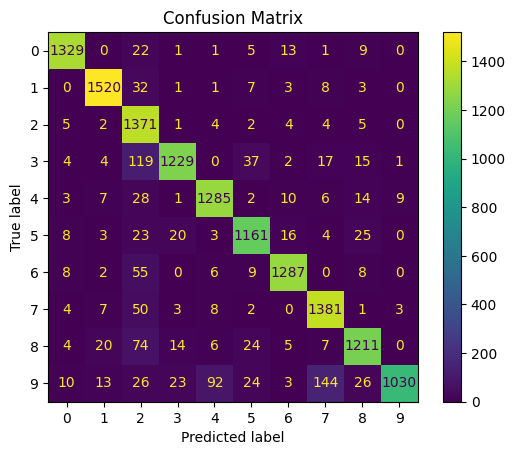


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1381
           1       0.96      0.97      0.96      1575
           2       0.76      0.98      0.86      1398
           3       0.95      0.86      0.90      1428
           4       0.91      0.94      0.93      1365
           5       0.91      0.92      0.92      1263
           6       0.96      0.94      0.95      1375
           7       0.88      0.95      0.91      1459
           8       0.92      0.89      0.90      1365
           9       0.99      0.74      0.85      1391

    accuracy                           0.91     14000
   macro avg       0.92      0.91      0.91     14000
weighted avg       0.92      0.91      0.91     14000



In [10]:
cm = confusion_matrix(labels, predictions)
# Get unique class labels
unique_labels = np.unique(labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels) # Use unique labels
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=unique_labels.astype(str))) # Use unique labels as target names

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,space_eval
from pprint import pprint
from sklearn.model_selection import cross_val_score
import numpy as np

In [12]:
def objective(params):
    # clf = RandomForestClassifier(**params)
    nn_clf = NeuralNetwork(**params)
    # nn = NeuralNetwork(input_size=784, output_size=10,
    #                # Hyperparameters
    #                hidden_size=300,batch_size = 128, learning_rate = 0.1,epochs = 20)
    score = cross_val_score(nn_clf, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [13]:
input_size = 784
output_size=10
print(int(np.sqrt(input_size+1)))

28


In [14]:
input_size = 784
output_size=10
space = {
    'input_size': hp.choice('input_size', [input_size]),
    'output_size': hp.choice('output_size', [output_size]),
    "epochs": hp.choice("epochs",[20]),

    'hidden_size': hp.uniformint("hidden_size", int(np.sqrt(input_size+1)), int((input_size+1)/2)),
    'batch_size': hp.uniformint("batch_size", int(X_train.shape[0]/1000), int(X_train.shape[0]/100)),
    "learning_rate": hp.uniform('learning_rate', 0.001, 0.1),

}


In [ ]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
best_params = space_eval(space=space,hp_assignment=best)
print("Best parameters: ")
pprint(best_params)

  3%|▎         | 3/100 [07:47<3:37:22, 134.45s/trial, best loss: -0.9626250000000001]

In [ ]:
best_NN_clf = NeuralNetwork(**best_params)
best_NN_clf.fit(X_train, y_train)

y_pred = best_NN_clf.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
labels = np.argmax(y_test, axis=1)

In [ ]:
accuracy = accuracy_score(labels,predictions)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(labels, predictions)
# Get unique class labels
unique_labels = np.unique(labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels) # Use unique labels
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=unique_labels.astype(str))) # Use unique labels as target names

# 5 sklearn Neural Net

5. Implement the same neural network using sklearn and compare the results with the NumPy implementation. (4 marks)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)



6. Plot the training and validation loss/accuracy curves (for both experiments). (3 marks)

In [ ]:
# Normalize the array
max_values = np.max(inputs, axis=0)
min_values = np.min(inputs, axis=0)

normalized_array = (inputs - min_values) / (max_values - min_values)
normalized_array = np.nan_to_num(normalized_array)  # Replace NaN values with 0



In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [9]:
# Initialize network
nn = NeuralNetwork(input_size=784, output_size=10)

# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.1
hidden_size=300

for epoch in range(epochs):
    # Shuffle data
    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    y_shuffled = y_train[permutation]

    # Mini-batch training
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # Forward pass
        y_pred = nn.forward(X_batch)

        # Backpropagation
        nn.backprop(X_batch, y_batch, y_pred, learning_rate)

    # Compute epoch loss
    y_pred = nn.forward(X_train)
    loss = nn.compute_loss(y_pred, y_train)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


KeyboardInterrupt: 

In [ ]:
# def compute_accuracy(X, y):
y_pred = nn.forward(X_test)
predictions = np.argmax(y_pred, axis=1)
labels = np.argmax(y_test, axis=1)
print(accuracy_score(labels,predictions))
# return np.mean(predictions == labels)

# print(f"\nTraining Accuracy: {compute_accuracy(X_train, y_train):.4f}")
# print(f"Test Accuracy: {compute_accuracy(X_test, y_test):.4f}")


0.9946428571428572


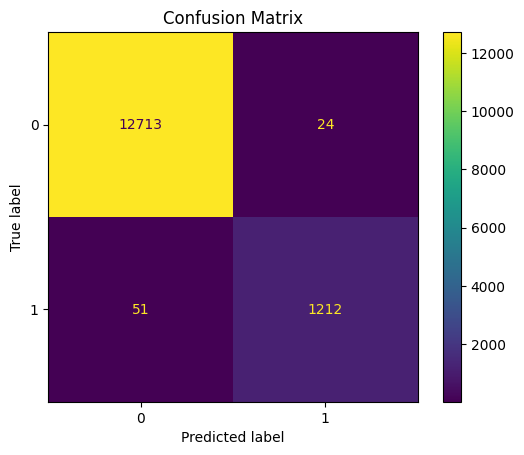


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12737
           1       0.98      0.96      0.97      1263

    accuracy                           0.99     14000
   macro avg       0.99      0.98      0.98     14000
weighted avg       0.99      0.99      0.99     14000



In [ ]:
cm = confusion_matrix(labels, predictions)
# Get unique class labels
unique_labels = np.unique(labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels) # Use unique labels
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=unique_labels.astype(str))) # Use unique labels as target names

In [ ]:
# %%script false --no-raise-error
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim,inputs, targets):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.inputs = inputs
        self.targets = targets.reshape(-1,1)
        # print(self.targets.shape)

        self.weights1 = np.random.rand(input_dim, hidden_dim)
        self.weights2 = np.random.rand(hidden_dim, output_dim)
        self.bias1 = np.zeros((1, hidden_dim))
        self.bias2 = np.zeros((1, output_dim))

    def forward_propagation(self):

        hidden_layer_input = np.dot(self.inputs, self.weights1) + self.bias1
        self.hidden_layer_output = relu(hidden_layer_input)

        output_layer_input = np.dot(self.hidden_layer_output, self.weights2) + self.bias2
        self.output_layer_output = sigmoid(output_layer_input)
        # print(self.output_layer_output.shape)
        # sys.exit()
        # return hidden_layer_output, output_layer_output

    def backward_propagation(self):
        # , targets, hidden_layer_output, output_layer_output):

        d_output = 2 * (self.output_layer_output - self.targets)
        self.d_weights2 = np.dot(self.hidden_layer_output.T, d_output * sigmoid_derivative(self.output_layer_output))
        self.d_bias2 = np.sum(d_output * sigmoid_derivative(self.output_layer_output), axis=0, keepdims=True)

        d_hidden_layer = np.dot(d_output * sigmoid_derivative(self.output_layer_output), self.weights2.T) * relu_derivative(self.hidden_layer_output)
        self.d_weights1 = np.dot(self.inputs.T, d_hidden_layer)
        self.d_bias1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

        # return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self,learning_rate):
        # , d_weights1, d_bias1, d_weights2, d_bias2, learning_rate):
        self.weights1 -= learning_rate * self.d_weights1
        self.bias1 -= learning_rate * self.d_bias1
        self.weights2 -= learning_rate * self.d_weights2
        self.bias2 -= learning_rate * self.d_bias2

    def runner(self, epochs, learning_rate):
        # inputs, targets, epochs, learning_rate
        for epoch in tqdm(range(epochs)):
            # hidden_layer_output, output_layer_output = self.forward_propagation(inputs)
            # d_weights1, d_bias1, d_weights2, d_bias2 = self.backward_propagation(inputs, targets, hidden_layer_output, output_layer_output)
            # self.update_weights(d_weights1, d_bias1, d_weights2, d_bias2, learning_rate)

            self.forward_propagation()
            self.backward_propagation()
            self.update_weights(learning_rate=learning_rate)

                # Print loss every 1000 epochs
            if epoch % 1000 == 0:
                loss = np.mean(np.square(self.output_layer_output - self.targets))
                print(f"\nEpoch {epoch+1}, Loss: {loss}")
                gc.collect()

        # _, final_output =
        self.forward_propagation(self.inputs)
        print("Final Predictions:")
        print(self.output_layer_output)

In [ ]:
nn = NeuralNetwork(input_dim=IL_n, hidden_dim=n_neurons_HL, output_dim=1,inputs=inputs,targets=targets)
learning_rate = 0.1
epochs = 10000
nn.runner(epochs, learning_rate)

  0%|          | 1/10000 [00:01<3:26:26,  1.24s/it]

Epoch 1, Loss: 20.27237142857143


  1%|          | 107/10000 [01:50<2:28:55,  1.11it/s]

In [ ]:
sys.exit()

In [ ]:
nn = NeuralNetwork(input_dim=IL_n, hidden_dim=n_neurons_HL, output_dim=1,input=inputs,targets=targets)


learning_rate = 0.1
epochs = 10000

for epoch in range(epochs):
    hidden_layer_output, output_layer_output = nn.forward_propagation(inputs)
    d_weights1, d_bias1, d_weights2, d_bias2 = nn.backward_propagation(inputs, targets, hidden_layer_output, output_layer_output)
    nn.update_weights(d_weights1, d_bias1, d_weights2, d_bias2, learning_rate)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        loss = np.mean(np.square(output_layer_output - targets))
        print(f"Epoch {epoch+1}, Loss: {loss}")

# Final predictions
_, final_output = nn.forward_propagation(inputs)
print("Final Predictions:")
print(final_output)


In [ ]:
class Neuron:
    def __init__(self,value):
        self.value = value
class hidden_layer


In [ ]:
class aHL:
    def __init__(self,mnist_784_df):


    def forward_prop_relu(self,input,weight):
        return np.maximum(0, input*weight)




In [ ]:
X.to_csv("mnist_784.csv",index=False,header=True)

In [ ]:
display(X.head().T)

In [ ]:
df = pd.DataFrame(X, columns=[f'Pixel_{i}'for i in range(X.shape[-1])])

In [ ]:
display(df.head())

In [ ]:
y.head()

In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim,inputs, targets):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.inputs = inputs
        self.targets = targets

        self.weights1 = np.random.rand(input_dim, hidden_dim)
        self.weights2 = np.random.rand(hidden_dim, output_dim)
        self.bias1 = np.zeros((1, hidden_dim))
        self.bias2 = np.zeros((1, output_dim))

    def forward_propagation(self):

        hidden_layer_input = np.dot(self.inputs, self.weights1) + self.bias1
        hidden_layer_output = relu(hidden_layer_input)

        output_layer_input = np.dot(hidden_layer_output, self.weights2) + self.bias2
        output_layer_output = sigmoid(output_layer_input)

        return hidden_layer_output, output_layer_output

    def backward_propagation(self, targets, hidden_layer_output, output_layer_output):

        d_output = 2 * (output_layer_output - targets)
        d_weights2 = np.dot(hidden_layer_output.T, d_output * sigmoid_derivative(output_layer_output))
        d_bias2 = np.sum(d_output * sigmoid_derivative(output_layer_output), axis=0, keepdims=True)

        d_hidden_layer = np.dot(d_output * sigmoid_derivative(output_layer_output), self.weights2.T) * relu_derivative(hidden_layer_output)
        d_weights1 = np.dot(self.inputs.T, d_hidden_layer)
        d_bias1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

        return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self, d_weights1, d_bias1, d_weights2, d_bias2, learning_rate):
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2

    def runner(self, epochs, learning_rate):
        # inputs, targets, epochs, learning_rate
        for i in range(epochs):
            # hidden_layer_output, output_layer_output = self.forward_propagation(inputs)
            # d_weights1, d_bias1, d_weights2, d_bias2 = self.backward_propagation(inputs, targets, hidden_layer_output, output_layer_output)
            # self.update_weights(d_weights1, d_bias1, d_weights2, d_bias2, learning_rate)

            self.forward_propagation()
            self.backward_propagation()
            self.update_weights()

            if i % 100 == 0:
                print(f"Loss: {np.mean(np.square(output_layer_output - targets))}")